In [1]:
contributor = "Nada"

### Step 1: Import Libraries

In [2]:
import json
import numpy as np
import pandas as pd
import csv
from datetime import datetime
import os
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
import plotly.graph_objects as go
from pandarallel import pandarallel
import matplotlib.pyplot as plt
pandarallel.initialize(progress_bar=True)
import pytz

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


### Step 2: Load and Preprocess Data

In [3]:
# Directory and file name pattern
directory = 'Cleaning/trial_week/clean_data'
file_base = 'clean_2024-01-'


# Generate the list of file names
files_names = [f'{file_base}{i}.json' for i in range(28, 32)]

# Generate the list of file directories
files = [os.path.join(directory, file_name) for file_name in files_names]

data = []

In [4]:
# Load data from each JSON file
for file_name in files:
    with open(file_name, 'r') as file:
        for line in file:
            data.append(json.loads(line))

# Create a DataFrame
df = pd.DataFrame(data)

# Step 1: Drop the 'time_diff' attribute if it exists
if 'time_diff' in df.columns:
    df.drop('time_diff', axis=1, inplace=True)

# # Step 2: Redefine the features after dropping 'time_diff'
# X = df_features.drop(columns=['time_diff'], errors='ignore')

# Calculate trip time in seconds
df['trip_time'] = df['time']

# Now, drop the 'time' column
df.drop(columns=['time'], inplace=True)

# Drop rows with missing values (if any)
df.dropna(inplace=True)

In [5]:
# Display the DataFrame to verify
print(df.columns)

Index(['trip_id', 'time_gap', 'dist', 'lats', 'driverID', 'weekID', 'timeID',
       'dateID', 'lngs', 'dist_gap', 'trip_time'],
      dtype='object')


### Step 3: Prepare Features and Target

In [6]:
# Feature extraction functions
def extract_features(row):
    features = {}
    features['mean_time_gap'] = np.mean(row['time_gap'])
    features['std_time_gap'] = np.std(row['time_gap'])
    features['min_time_gap'] = np.min(row['time_gap'])
    features['max_time_gap'] = np.max(row['time_gap'])
    
    features['mean_lat'] = np.mean(row['lats'])
    features['std_lat'] = np.std(row['lats'])
    features['min_lat'] = np.min(row['lats'])
    features['max_lat'] = np.max(row['lats'])
    
    features['mean_lng'] = np.mean(row['lngs'])
    features['std_lng'] = np.std(row['lngs'])
    features['min_lng'] = np.min(row['lngs'])
    features['max_lng'] = np.max(row['lngs'])
    
    features['mean_dist_gap'] = np.mean(row['dist_gap'])
    features['std_dist_gap'] = np.std(row['dist_gap'])
    features['min_dist_gap'] = np.min(row['dist_gap'])
    features['max_dist_gap'] = np.max(row['dist_gap'])
    
    return pd.Series(features)

### Step 4: Split the Data

In [7]:
# Split the data
# X_train, X_test, y_train, y_test = train_test_split(df, df['trip_time'], test_size=0.25, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(df, df['trip_time'], test_size=0.25, random_state=None)

# Convert non-numeric columns to numeric or drop them
def handle_non_numeric_columns(df):
    non_numeric_cols = df.select_dtypes(include=['object']).columns
    for col in non_numeric_cols:
        # Check if the column contains lists
        if df[col].apply(lambda x: isinstance(x, list)).any():
            # Convert lists to strings or drop the column
            df[col] = df[col].apply(lambda x: str(x) if isinstance(x, list) else x)
        # Factorize the column
        df[col] = pd.factorize(df[col])[0]
    return df

X_train = handle_non_numeric_columns(X_train)
X_test = handle_non_numeric_columns(X_test)



# Convert non-numeric columns to numeric or drop them
# non_numeric_cols = X_train.select_dtypes(include=['object']).columns
# X_train[non_numeric_cols] = X_train[non_numeric_cols].apply(lambda col: pd.factorize(col)[0])
# X_test[non_numeric_cols] = X_test[non_numeric_cols].apply(lambda col: pd.factorize(col)[0])

# Ensure all features are numeric
assert X_train.select_dtypes(include=['object']).empty, "There are still non-numeric columns in X_train"
assert X_test.select_dtypes(include=['object']).empty, "There are still non-numeric columns in X_test"

# Drop 'trip_time' from the training data
X_train_features = X_train.drop(columns=['trip_time'])
X_test_features = X_test.drop(columns=['trip_time'])

In [8]:
# print(X_train_features.columns)
# print(X_test_features.columns)
# print(X_train.columns)
# print(X_test.columns)
# print(y_train)

### Step 5: Hyperparameter Tuning and Model Training

##### * Randomized Parameter Search

In [9]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 100)]
# Number of features to consider at every split
max_features = ['sqrt', 'log2', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

# Initialize RandomForestRegressor
model = RandomForestRegressor()

# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(error_score='raise', estimator = model, param_distributions = random_grid, n_iter = 50, cv = 3, verbose=2, random_state=42, n_jobs = 2)

# Fit the random search model
rf_random.fit(X_train_features, y_train)

# Retrieve the best parameters
rf_random.best_params_


{'n_estimators': [200, 218, 236, 254, 272, 290, 309, 327, 345, 363, 381, 400, 418, 436, 454, 472, 490, 509, 527, 545, 563, 581, 600, 618, 636, 654, 672, 690, 709, 727, 745, 763, 781, 800, 818, 836, 854, 872, 890, 909, 927, 945, 963, 981, 1000, 1018, 1036, 1054, 1072, 1090, 1109, 1127, 1145, 1163, 1181, 1200, 1218, 1236, 1254, 1272, 1290, 1309, 1327, 1345, 1363, 1381, 1400, 1418, 1436, 1454, 1472, 1490, 1509, 1527, 1545, 1563, 1581, 1600, 1618, 1636, 1654, 1672, 1690, 1709, 1727, 1745, 1763, 1781, 1800, 1818, 1836, 1854, 1872, 1890, 1909, 1927, 1945, 1963, 1981, 2000], 'max_features': ['sqrt', 'log2', None], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': None,
 'max_depth': 10,
 'bootstrap': True}

In [28]:
import time
start_time = time.time()
model.fit(X_train_features, y_train)  # Replace with your model fitting code
elapsed_time = time.time() - start_time
print(f"Time taken for one fit: {elapsed_time} seconds")
total_time = elapsed_time * 150
print(f"Estimated total time: {total_time} seconds")

Time taken for one fit: 27.57887840270996 seconds
Estimated total time: 4136.831760406494 seconds


In [29]:
import time

# Start timing
start_time = time.time()

# Simulate a single fit (you should replace this with your actual model fitting code)
model.fit(X_train_features, y_train)  # Replace with your actual model fitting code

# Calculate the elapsed time for one fit
elapsed_time = time.time() - start_time
print(f"Time taken for one fit: {elapsed_time:.2f} seconds")

# Calculate the total time assuming 150 fits and using 3 cores
# Since 3 cores are used, the total time is reduced by a factor of 3
total_time = (elapsed_time * 150) / 3

# Convert the total time to minutes
total_time_minutes = total_time / 60
print(f"Estimated total time: {total_time_minutes:.2f} minutes")


Time taken for one fit: 23.70 seconds
Estimated total time: 19.75 minutes


##### * Parameter Grid Search

In [18]:
# param_grid = {
#     'n_estimators': list(range(1, 202, 50)),
#     'max_depth': list(range(1, 8)),
#     'min_samples_leaf': list(range(1, 10)),
#     'max_leaf_nodes': [None] + list(range(10, 20, 2)),
#     'random_state': [42],
#     'criterion': ['squared_error', 'absolute_error']
# }

# grid_search = GridSearchCV(RandomForestRegressor(), param_grid, cv=5, refit=True, verbose=1, scoring='neg_root_mean_squared_error')
# grid_search.fit(X_train, y_train)

# best_params = grid_search.best_params_
# model = RandomForestRegressor(**best_params)
# model.fit(X_train, y_train)

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error

# # Define the parameter grid
# param_grid = {
#     'n_estimators': [100, 200, 300, 400, 500],
#     'max_depth': [None, 10, 20, 30, 40],
#     'min_samples_leaf': [1, 2, 3, 4, 5],
#     'max_leaf_nodes': [None, 10, 20, 30, 40],
#     'criterion': ['squared_error', 'absolute_error'],
#     'max_features': ['sqrt', 'log2', None]
# }

# # Initialize the model
# model = RandomForestRegressor(random_state=42)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

# # Fit the model to find the best parameters
# grid_search.fit(X_train.drop(columns=['trip_time']), y_train)

# # Retrieve the best parameters
# best_params = grid_search.best_params_

# print("Best Parameters Found:")
# print(best_params)

# # Train the model with the best parameters
# best_model = RandomForestRegressor(**best_params, random_state=42)
# best_model.fit(X_train.drop(columns=['trip_time']), y_train)

# # Evaluate the best model
# y_pred = best_model.predict(X_test.drop(columns=['trip_time']))
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)
 
# print(f'Root Mean Squared Error (RMSE) with Best Parameters: {rmse}')


##### * Narrow down the parameter grid search

Later...

##### * Only one parameter

In [ ]:
# # Recommended initial hyperparameter values
# n_estimators = 300
# max_depth = None  # Let the tree grow until all leaves are pure or until they contain less than min_samples_split samples
# min_samples_leaf = 3  # The minimum number of samples required to be at a leaf node
# max_leaf_nodes = None  # Let the trees grow until all leaves are pure or until they contain less than min_samples_split samples
# random_state = 42  # Ensures reproducibility
# criterion = 'squared_error'  # Default criterion for regression tasks
# max_features = 'sqrt'  # Consider sqrt of the number of features for each split

# # Initialize and train the model with the recommended values
# model = RandomForestRegressor(
#     n_estimators=n_estimators,
#     max_depth=max_depth,
#     min_samples_leaf=min_samples_leaf,
#     max_leaf_nodes=max_leaf_nodes,
#     random_state=random_state,
#     criterion=criterion,
#     max_features=max_features
# )

# # Drop 'trip_time' from the training data
# X_train_features = X_train.drop(columns=['trip_time'])
# X_test_features = X_test.drop(columns=['trip_time'])


# model.fit(X_train.drop(columns=['trip_time']), y_train)

#### Evaluate the model using RMSE

In [ ]:
# Evaluate the model using RMSE
y_pred = model.predict(X_test.drop(columns=['trip_time']))
mse = mean_squared_error(y_test, y_pred, squared=False)
rmse = np.sqrt(mse)

print(f'Root Mean Squared Error (RMSE): {rmse}')


#### Feature Importance Analysis

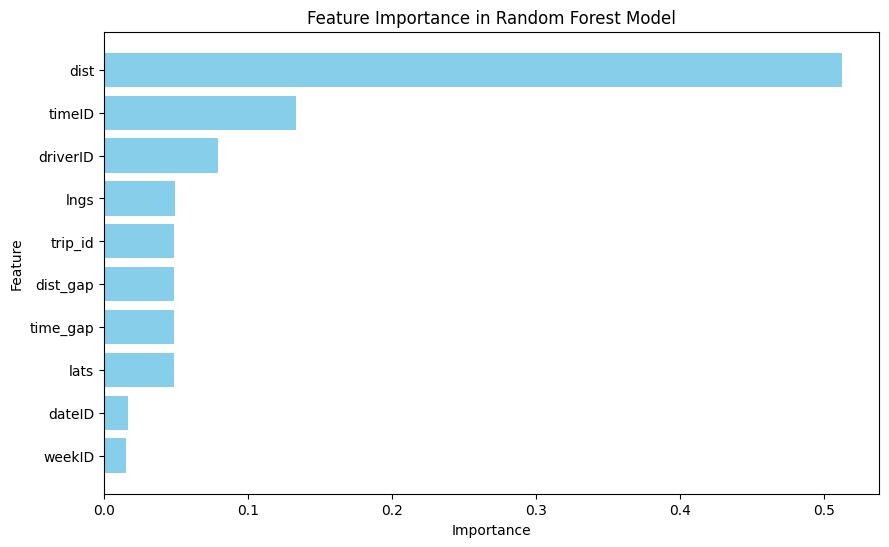

,Feature,Importance
2,dist,0.512558
6,timeID,0.133652
4,driverID,0.078945
8,lngs,0.048988
0,trip_id,0.048656
9,dist_gap,0.048534
1,time_gap,0.048490
3,lats,0.048417
7,dateID,0.016348
5,weekID,0.015413


In [28]:
feature_importances = model.feature_importances_

# Step 6: Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': X_train_features.columns,
    'Importance': feature_importances
})

# Step 7: Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Step 8: Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Random Forest Model')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()

# Output the importance DataFrame for review
importance_df

### Step 6: Evaluate the Model with Learning Curves

In [29]:
# Get current timestamp in Cairo time
cairo_tz = pytz.timezone('Africa/Cairo')
timestamp = datetime.now(cairo_tz).strftime('%Y-%m-%dT%H:%M:%S')

# Generate a unique label based on the timestamp
label = 'Model_Run_' + timestamp.replace(':', '').replace('-', '').split('.')[0]
# label = 'Model_Run_' + datetime.now().strftime("%Y%m%d_%H%M%S")

print(timestamp)
print(label)

2024-08-09T21:18:36
Model_Run_20240809T211836


In [30]:
train_sizes, train_scores, valid_scores = learning_curve(
    model, X_train.drop(columns=['trip_time']), y_train, train_sizes=np.linspace(0.1, 1, 10), cv=5, scoring='neg_root_mean_squared_error')


fig = go.Figure()
fig.add_trace(go.Scatter(x=train_sizes, y=-np.mean(train_scores, axis=1), name='Training error'))
fig.add_trace(go.Scatter(x=train_sizes, y=-np.mean(valid_scores, axis=1), name='Validation error'))
fig.update_layout(
    title='Learning Curve: ' + label,
    xaxis_title='Number of Training Examples',
    yaxis_title='Root Mean Squared Error (RMSE)',
    legend_title='Error Type'
)
fig.show()

# Specify the directory and file name
output_directory = 'Careem_RFR_Figures/'  # Replace with your directory path
if not os.path.exists(output_directory):
    os.makedirs(output_directory)  # Create the directory if it doesn't exist
output_file = os.path.join(output_directory, f'learning_curve_v2.1_{label}.png')

# Save the figure
fig.write_image(output_file)

### Step 7: Make Predictions and Calculate Errors

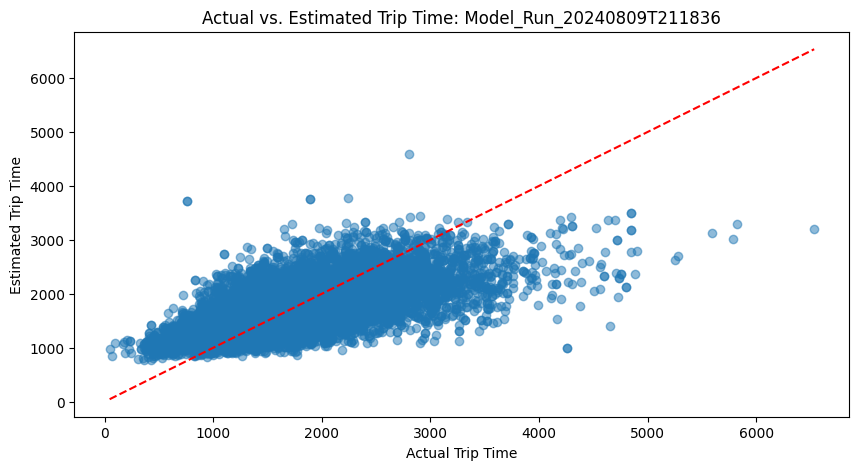

Mean Absolute Error (MAE): 398.84623408813525
R^2 Score: 0.4042803392019172


In [31]:
def estimations(test_data, model, feature_names):
    features_data = test_data[feature_names]
    test_data['trip_time_estimate'] = model.predict(features_data)
    test_data['error'] = test_data['trip_time'] - test_data['trip_time_estimate']
    test_data = test_data.query("error < 3600")
    return test_data

# Get the feature names used during training
feature_names = X_train.drop(columns=['trip_time']).columns.tolist()

def plot_graphs(plot_df):
    plt.figure(figsize=(10, 5))
    plt.scatter(plot_df['trip_time'], plot_df['trip_time_estimate'], alpha=0.5)
    plt.plot([plot_df['trip_time'].min(), plot_df['trip_time'].max()], 
             [plot_df['trip_time'].min(), plot_df['trip_time'].max()], 'r--')
    plt.xlabel('Actual Trip Time')
    plt.ylabel('Estimated Trip Time')
    plt.title('Actual vs. Estimated Trip Time: ' + label)

    # Save the figure
    if not os.path.exists(output_directory):
        os.makedirs(output_directory)  # Create the directory if it doesn't exist
    output_file = os.path.join(output_directory, f'actual_vs_estimated_v2.1_{label}.png')
    plt.savefig(output_file)
    plt.show()
    plt.close()

def get_metrics(plot_df):
    mae = mean_absolute_error(plot_df['trip_time'], plot_df['trip_time_estimate'])
    r2 = r2_score(plot_df['trip_time'], plot_df['trip_time_estimate'])
    print(f'Mean Absolute Error (MAE): {mae}')
    print(f'R^2 Score: {r2}')
    return mae, r2

# Assuming plot_df is defined from the previous estimations step
plot_df = estimations(X_test, model, feature_names)
plot_graphs(plot_df)
mae, r2 = get_metrics(plot_df)

### Step 8: Log the results

In [32]:
# Define the log file path
log_file_path = 'model_training_results_v2.1_log_.csv'

# Create a log file with headers if it doesn't exist
if not os.path.exists(log_file_path):
    with open(log_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Timestamp', 'Label', 'n_estimators', 'max_depth', 'min_samples_leaf', 'max_leaf_nodes', 'random_state', 'criterion', 'max_features', 'RMSE', 'MAE', 'R2_Score', 'Input_Data_Files', 'Contributor'])

def log_model_training(n_estimators, max_depth, min_samples_leaf, max_leaf_nodes, random_state, criterion, max_features, RMSE, MAE, R2_Score, input_data_files):
    # Log details into CSV file
    with open(log_file_path, mode='a', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([timestamp, label, n_estimators, max_depth, min_samples_leaf, max_leaf_nodes, random_state, criterion, max_features, RMSE, MAE, R2_Score, input_data_files, contributor])


# Example usage
RMSE = rmse
MAE = mae
R2_Score = r2
# Convert list of files to a comma-separated string
input_data_files = ', '.join(files_names)
# input_data_files = 'clean_2024-01-25.json, clean_2024-01-26.json, clean_2024-01-27.json, clean_2024-01-28.json, clean_2024-01-29.json'

log_model_training(n_estimators, max_depth, min_samples_leaf, max_leaf_nodes, random_state, criterion, max_features, RMSE, MAE, R2_Score, input_data_files)


In [ ]:
from sklearn import tree
tree.plot_tree(model.estimators_[0])